In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from prophet import Prophet

In [2]:
mbb=pd.read_csv('MBB.csv')
mbb

,Ticker,Date,Open,High,Low,Close,Volume
0,MBB,11/1/2011,2.625283,2.625283,2.498545,2.498545,2719290.0
1,MBB,11/2/2011,2.462402,2.498614,2.389979,2.389979,1255220.0
2,MBB,11/3/2011,2.353780,2.389992,2.281356,2.371886,1193910.0
3,MBB,11/4/2011,2.390005,2.390005,2.335687,2.335687,483860.0
4,MBB,11/7/2011,2.335777,2.335777,2.227136,2.227136,1158750.0
...,...,...,...,...,...,...,...
3080,MBB,03/07/2024,24.700000,24.800000,24.350000,24.400000,19759000.0
3081,MBB,03/08/2024,24.500000,24.500000,23.600000,23.600000,49382200.0
3082,MBB,03/11/2024,23.550000,23.600000,22.800000,22.950000,34911300.0
3083,MBB,03/12/2024,22.900000,23.250000,22.750000,23.100000,19120400.0


In [3]:
mbb= mbb[['Date', 'Close']]
mbb['Date'] = pd.to_datetime(mbb['Date'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_24156\3457643390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mbb['Date'] = pd.to_datetime(mbb['Date'])


In [5]:
split_time = 2500
train = mbb[:split_time]
test = mbb[split_time:]

train.shape, test.shape

((2500, 2), (585, 2))

In [7]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

line1 = go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train')
line2 = go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test')

st_fig.add_trace(line1)
st_fig.add_trace(line2)
st_fig.update_layout(title='Daily Close Stock Price MBB Period 2012-2024')
st_fig.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


C:\Users\DELL\AppData\Local\Temp\ipykernel_24156\2361287451.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



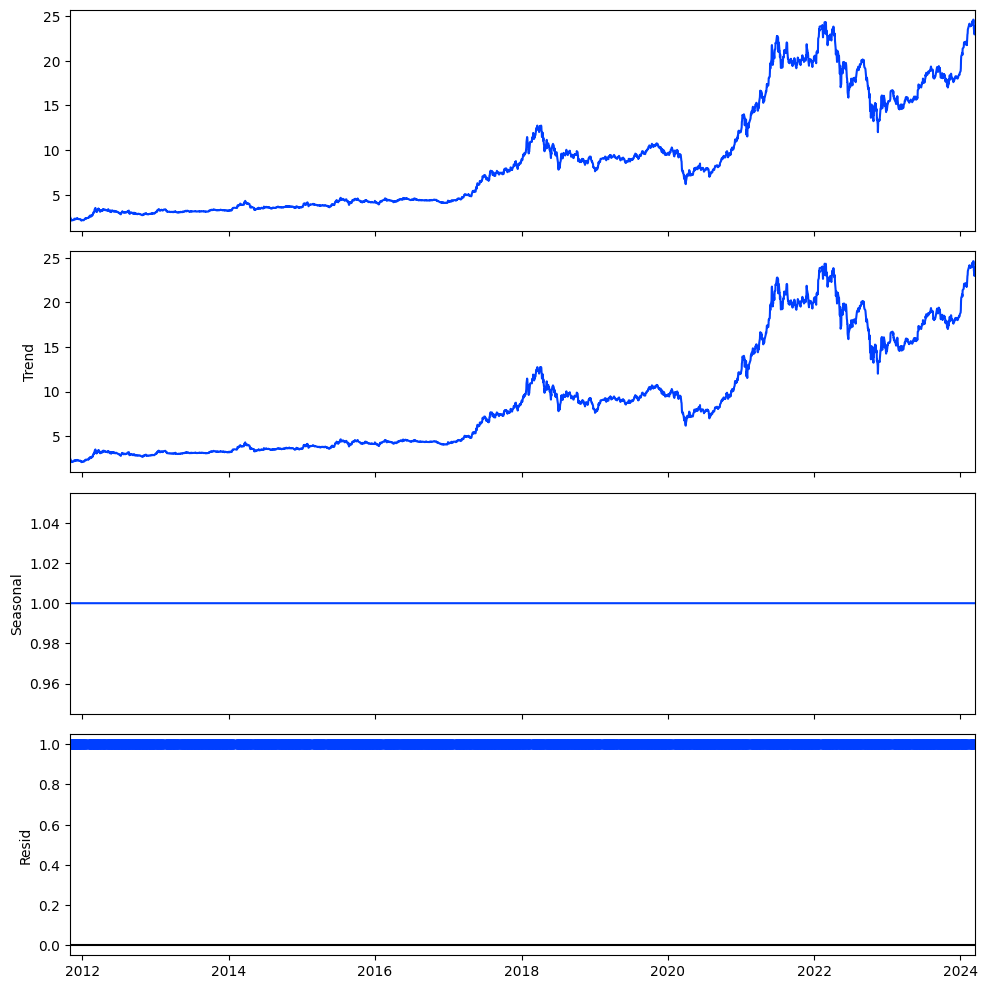

In [8]:
print(plt.style.available)
sd = mbb.copy().dropna()
sd.set_index('Date', inplace=True)

plt.style.use("seaborn-v0_8-bright")
plt.rc("figure", figsize=(10,10))

fig = seasonal_decompose(sd, model='multiplicative', period=1).plot()

fig.show()

# **ARIMA**

In [9]:
result = adfuller(train['Close'])
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'])
print(f'KPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

ADF Stattistics : 1.1841921708235696
P-value : 0.9958748255090786
KPSS Stattistics : 5.9378041772784815
P-value : 0.01


C:\Users\DELL\AppData\Local\Temp\ipykernel_24156\4195365602.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




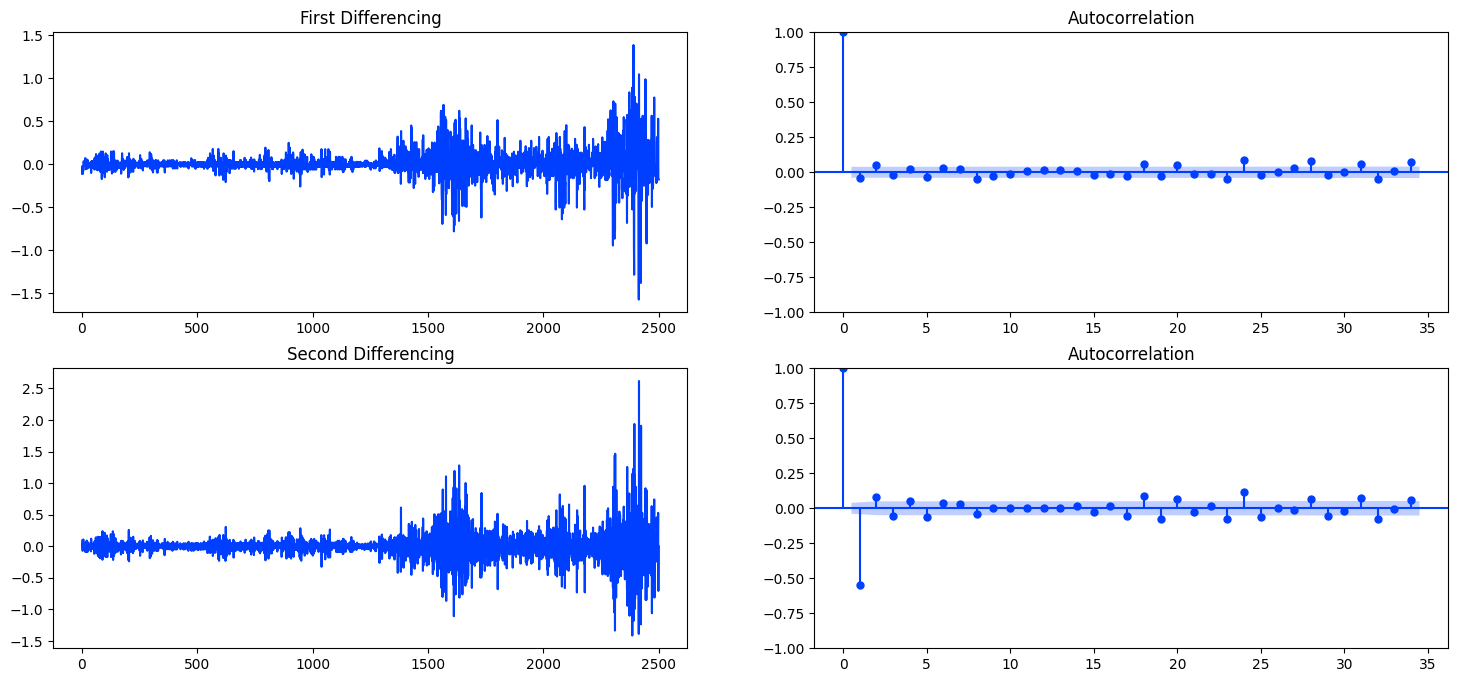

In [10]:
# Plot ACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_acf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_acf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

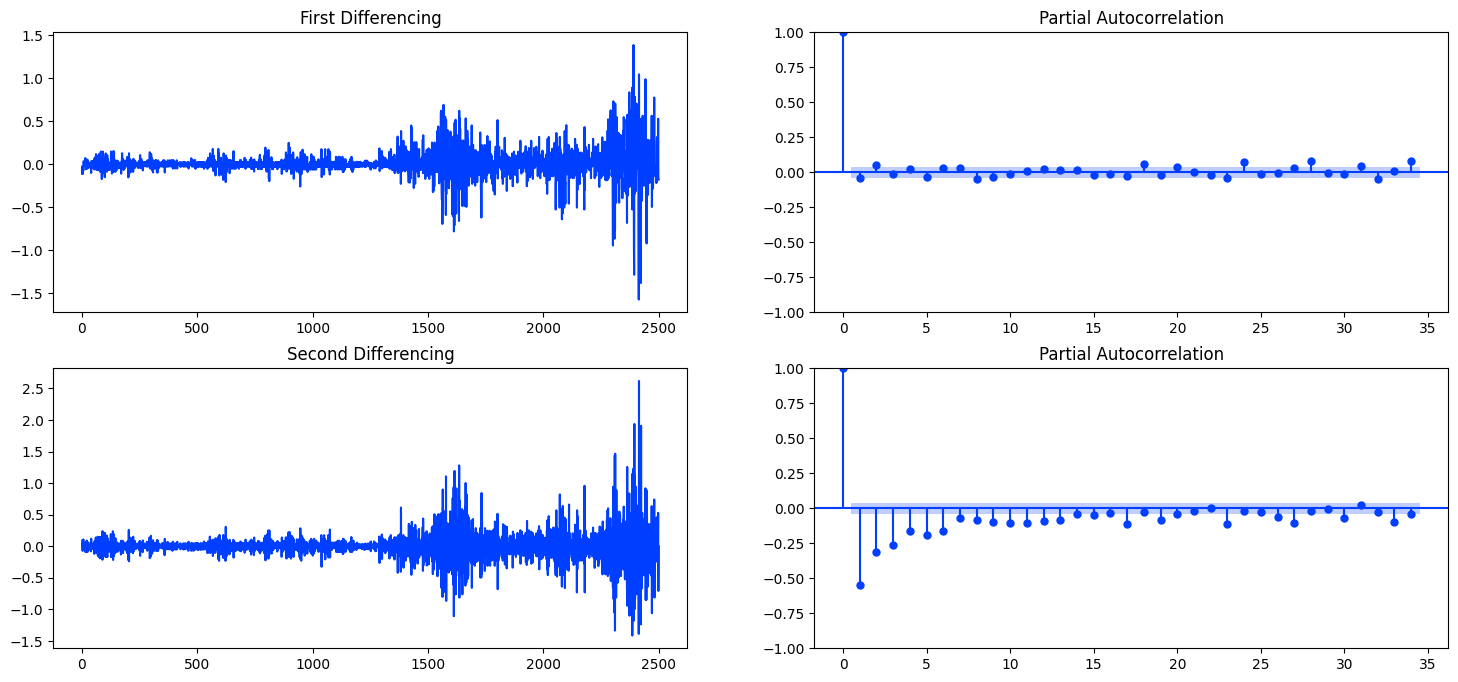

In [11]:
#Plot PACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_pacf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_pacf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

In [12]:
ndiffs(train['Close'], test='adf')

1

In [13]:
result = adfuller(train['Close'].diff().dropna())
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'].diff().dropna())
print(f'\nKPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

if result[1] < 0.05 and result_kpss[1] > 0.05:
  print('\nConclusion : Data stationer\n')
else:
  print('\nConclusion : Data not stationer\n')

ADF Stattistics : -8.11908283181881
P-value : 1.1692413463160638e-12

KPSS Stattistics : 0.4196366999863076
P-value : 0.0686910775921088

Conclusion : Data stationer



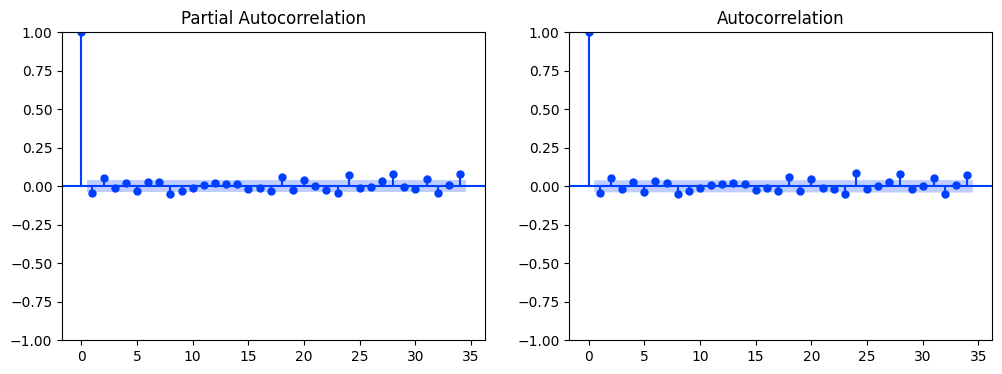

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

diff_once = train['Close'].diff()
plot_pacf(diff_once.dropna(), ax=ax[0])
plot_acf(diff_once.dropna(), ax=ax[1])

plt.show()

# **MODELING**


**ARIMA(1,1,1)**

In [15]:
model1 = ARIMA(train['Close'], order=(1, 1, 1), trend='t')
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2500
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 952.210
Date:                Thu, 14 Mar 2024   AIC                          -1896.420
Time:                        17:57:01   BIC                          -1873.125
Sample:                             0   HQIC                         -1887.962
                               - 2500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0071      0.003      2.164      0.030       0.001       0.014
ar.L1         -0.7523      0.056    -13.519      0.000      -0.861      -0.643
ma.L1          0.7064      0.060     11.820      0.0

**ARIMA(0,1,1)**

In [16]:
model2 = ARIMA(train['Close'], order=(0, 1, 1), trend='t')
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2500
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 948.032
Date:                Thu, 14 Mar 2024   AIC                          -1890.063
Time:                        17:57:04   BIC                          -1872.592
Sample:                             0   HQIC                         -1883.720
                               - 2500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0071      0.003      2.171      0.030       0.001       0.014
ma.L1         -0.0370      0.008     -4.383      0.000      -0.054      -0.020
sigma2         0.0274      0.000    102.980      0.0

**ARIMA(1,1,0)**

In [17]:
model3 = ARIMA(train['Close'], order=(1, 1, 0), trend='t')
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2500
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 948.228
Date:                Thu, 14 Mar 2024   AIC                          -1890.457
Time:                        17:57:08   BIC                          -1872.986
Sample:                             0   HQIC                         -1884.114
                               - 2500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0071      0.003      2.177      0.029       0.001       0.014
ar.L1         -0.0408      0.008     -4.829      0.000      -0.057      -0.024
sigma2         0.0274      0.000    102.918      0.0

# **FORCASTING**

In [18]:
#Prediction
prediction_arima = result1.get_prediction(start=1, end=len(mbb))
pred = prediction_arima.predicted_mean

pred_df = pd.DataFrame(pred.values, columns=['pred']).join(mbb['Date'])

In [19]:
#Forecast Next 100 Days
n_forecast = 100

forecast_arima = result1.get_forecast(steps=n_forecast)

yhat = forecast_arima.predicted_mean
yhat_conf_int = forecast_arima.conf_int(alpha=0.05)

yhat_date = pd.DataFrame(pd.date_range(start = '2024-03-13', periods = 100, freq='B'), columns=['Date'])

yhat_df = pd.DataFrame(yhat.values,  columns=['yhat']).join(yhat_date)

In [20]:
# Result Forecast
yhat_df

,yhat,Date
0,20.249708,2024-03-13
1,20.263782,2024-03-14
2,20.265634,2024-03-15
3,20.276680,2024-03-18
4,20.280810,2024-03-19
...,...,...
95,20.928096,2024-07-24
96,20.935195,2024-07-25
97,20.942294,2024-07-26
98,20.949393,2024-07-29


In [21]:
lower_series = pd.DataFrame(yhat_conf_int['lower Close'].values, columns=['lower']).join(yhat_date)
upper_series = pd.DataFrame(yhat_conf_int['upper Close'].values, columns=['upper']).join(yhat_date)

In [22]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = pred_df['Date'], y = pred_df['pred'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Prediction'))
st_fig.add_trace(go.Scatter(x = yhat_df['Date'], y = yhat_df['yhat'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Forecasting'))

st_fig.add_traces(go.Scatter(x=lower_series['Date'], y = lower_series['lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=upper_series['Date'], y = upper_series['upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.update_layout(title='ARIMA (0,1,1)')
st_fig.show()

In [23]:
rmse_arima =  mean_squared_error(test['Close'], pred_df['pred'][split_time:], squared=False)
rmse_arima

5.0268142015417006

# **FB Prophet Model**

In [24]:
train_fp = pd.DataFrame({'ds' : train['Date'], 'y' : train['Close']})
train_fp

,ds,y
0,2011-11-01,2.498545
1,2011-11-02,2.389979
2,2011-11-03,2.371886
3,2011-11-04,2.335687
4,2011-11-07,2.227136
...,...,...
2495,2021-11-01,20.075160
2496,2021-11-02,20.075160
2497,2021-11-03,20.605320
2498,2021-11-04,20.428600


In [25]:
model_fp = Prophet(daily_seasonality=True)
model_fp.fit(train_fp)

17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing


# **Forecast**

In [26]:
future = model_fp.make_future_dataframe(periods=len(test)+100, freq='B')
future

,ds
0,2011-11-01
1,2011-11-02
2,2011-11-03
3,2011-11-04
4,2011-11-07
...,...
3180,2024-06-17
3181,2024-06-18
3182,2024-06-19
3183,2024-06-20


In [27]:
forecast = model_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3180,2024-06-17,35.353131,29.290831,41.021137
3181,2024-06-18,35.383008,29.097893,41.037108
3182,2024-06-19,35.414243,29.165705,40.973777
3183,2024-06-20,35.438878,29.062456,40.969022
3184,2024-06-21,35.468222,29.052962,41.091262


In [28]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()


st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['yhat'], 
                            line = dict(color='green', width=2, dash='dot'), name= 'Forecasting'))


st_fig.update_layout(title='FB Prophet')
st_fig.show()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



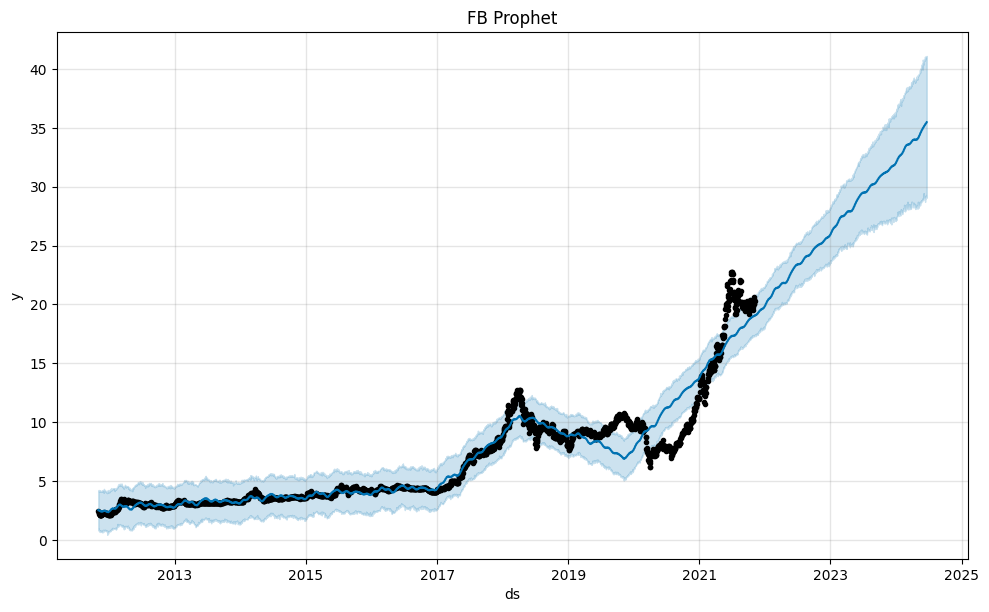

In [29]:
model_fp.plot(forecast)
plt.title('FB Prophet')
plt.show()

In [30]:
rmse_fp =  mean_squared_error(test['Close'], forecast['yhat'][split_time:split_time+len(test)], squared=False)
rmse_fp

9.147445373316875